# Create new utility function

Import data.

In [1]:
%load_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.from_sdf(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

load data


In [2]:
building_blocks = dg.datasets.enamine(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630.fpb')

# align fingerprints to building blocks
print('align fingerprints')
fingerprints = dg.utils.sort_fingerprints(fingerprints, building_blocks)

# partition building blocks according to functional groups
print('partition building blocks')
templates = dg.utils.get_unique_reactants(reactions)
building_blocks = dg.utils.partition_building_blocks(building_blocks, templates, out_dir=path)

align fingerprints
partition building blocks


Create inputs to the DrugEnv.

In [3]:
import numpy as np
from dgym.envs.library_designer import LibraryDesigner
from dgym.envs.oracle import DGLOracle, RDKitOracle
from dgym.envs.evaluator import ClassicEvaluator, UtilityFunction

# create library designer
library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

# create assays
log_P_oracle = RDKitOracle('MolLogP')
log_S_oracle = DGLOracle('GCN_canonical_ESOL')

# create evaluators
log_S_evaluator = ClassicEvaluator(ideal=(-2, 0), acceptable=(-4, 0.5))
log_P_evaluator = ClassicEvaluator(ideal=(1, 4), acceptable=(0, 5))

# create utility function
utility_function = UtilityFunction(
    oracles =    [log_S_oracle,    log_P_oracle],
    evaluators = [log_S_evaluator, log_P_evaluator],
    strategy = lambda x: np.multiply(*x)
)

utility = utility_function(deck)
worst_molecules = utility.argsort().tolist()[:25]

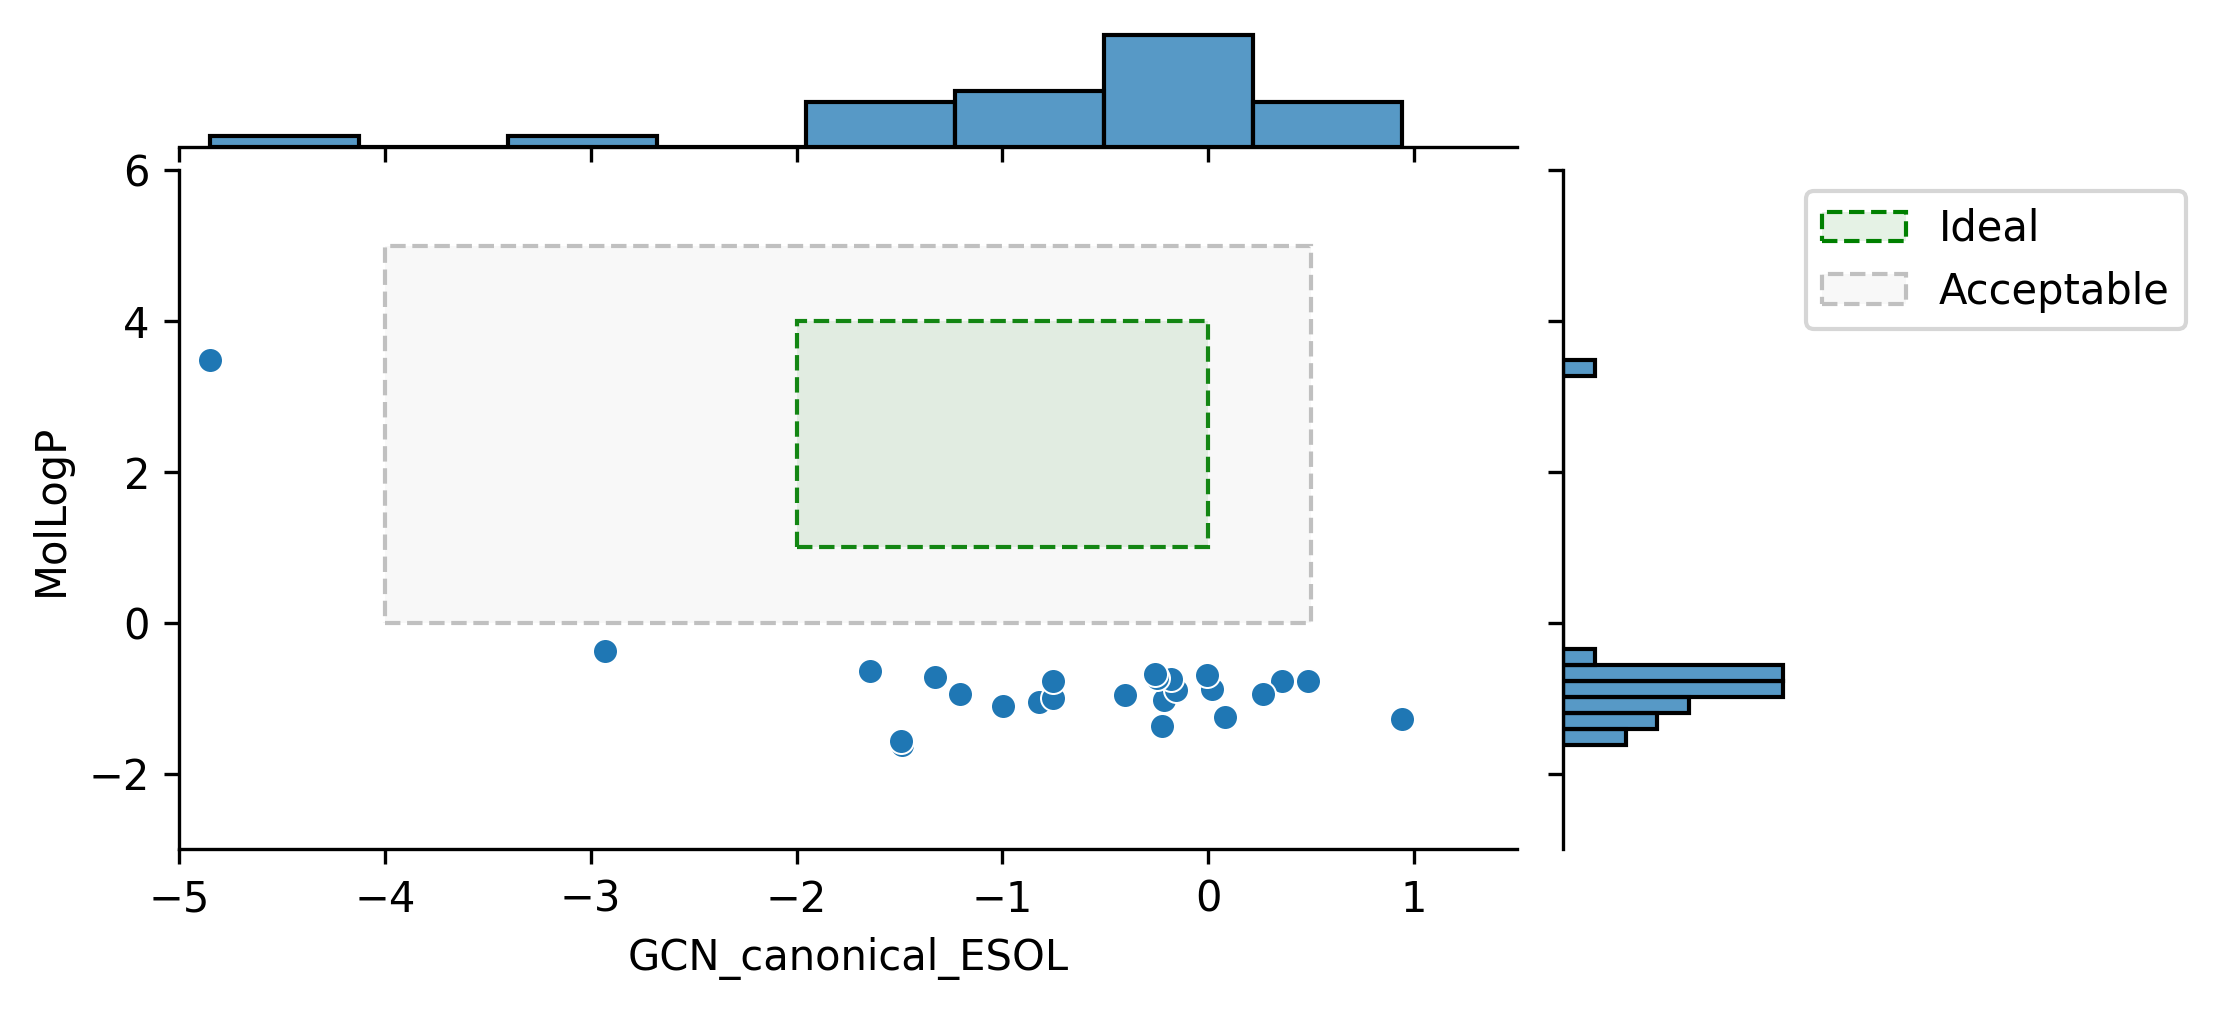

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

g = utility_function.plot(deck[worst_molecules], plot_cycle=False)

g.ax_joint.set_xlim(-5, 1.5)
g.ax_joint.set_ylim(-3, 6)
plt.show()

First, set up the environment.

In [5]:
from dgym.envs.drug_env import DrugEnv
from dgym.agents import SequentialDrugAgent
from tqdm.notebook import tqdm

def run_experiment(
    num_trials,
    library,
    epsilon,
    fraction_random,
    num_analogs,
    branch_factor,
    budget=10_000,
):
    drug_env = DrugEnv(
        library_designer,
        library = deck[worst_molecules],
        assays = utility_function.oracles,
        budget = budget,
        utility_function = utility_function,
    )

    drug_agent = SequentialDrugAgent(
        action_space = drug_env.action_space,
        utility_function = utility_function,
        epsilon = epsilon,
        fraction_random = fraction_random,
        num_analogs = num_analogs,
        branch_factor = branch_factor
    )

    results = []
    for trial in tqdm(range(num_trials)):

        observations, info = drug_env.reset()

        while True:
            
            action = drug_agent.act(observations)
            observations, reward, terminated, truncated, info = drug_env.step(action)
            
            result = {
                'trial': trial,
                'epsilon': epsilon,
                'fraction_random': fraction_random,
                'num_analogs': num_analogs,
                'branch_factor': branch_factor
            }

            if terminated:
                cost = len(drug_env.library) - len(drug_env._library_0)
                result.update({'cost': cost, 'outcome': 1})
                break

            if truncated:
                result.update({'outcome': 0})
                break

        results.append(result)
        
    return results

In [24]:
# results = []
epsilons = [0.0] # , 0.1, 0.2, 0.4, 0.8, 1.0
for epsilon in epsilons:
    result = run_experiment(
        # experiment
        num_trials = 500,

        # env
        library = deck[worst_molecules],
        epsilon = epsilon,

        # agent
        fraction_random = 0.2,
        num_analogs = 1,
        branch_factor = 2
    )
    results.extend(result)

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
pd.read_csv('../../dgym-data/out/experiments/epsilon_sequential_agent.csv')

In [46]:
# import pandas as pd
# pd.DataFrame(results).to_csv('../../dgym-data/out/experiments/epsilon_sequential_agent.csv')

In [20]:
# sns.reset_defaults()
# g = utility_function.plot(drug_env.library)

# # g.ax_joint.set_xlim(-9, 1.5)
# # g.ax_joint.set_ylim(-3, 6)
# plt.show()

In [43]:
def ecdf(costs):
    costs = np.array([c for c in costs])
    costs_sorted = np.sort(costs)
    probs = 1. * np.arange(1, len(costs) + 1) / len(costs)

    costs_sorted = np.concatenate([[0.0], costs_sorted])
    probs = np.concatenate([[0.0], probs])
    
    return costs_sorted, probs

In [44]:
data = pd.DataFrame()
for epsilon in epsilons:
    raw_costs = [r['cost'] for r in df.to_dict('records') if r['epsilon'] == epsilon]
    cost, prob = ecdf(raw_costs)
    temp = pd.DataFrame({'cost': cost, 'prob': prob, 'epsilon': epsilon})
    data = pd.concat([data, temp])

AttributeError: 'NoneType' object has no attribute 'to_dict'

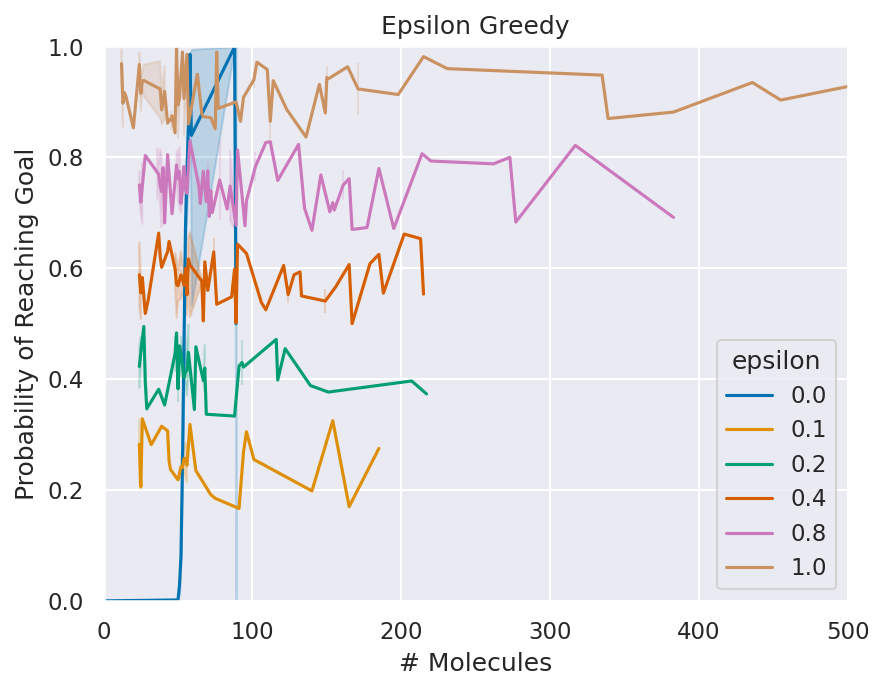

In [41]:
sns.set()
g = sns.lineplot(
    data,
    x='cost',
    y='prob',
    hue='epsilon',
    palette='colorblind'
)

g.set_title('Epsilon Greedy')
g.set_xlabel('# Molecules')
g.set_ylabel('Probability of Reaching Goal')
g.set_ylim([0, 1])
g.set_xlim(0, 500)

plt.gcf().set_dpi(150)
plt.show()

Draw lineage of best molecule.

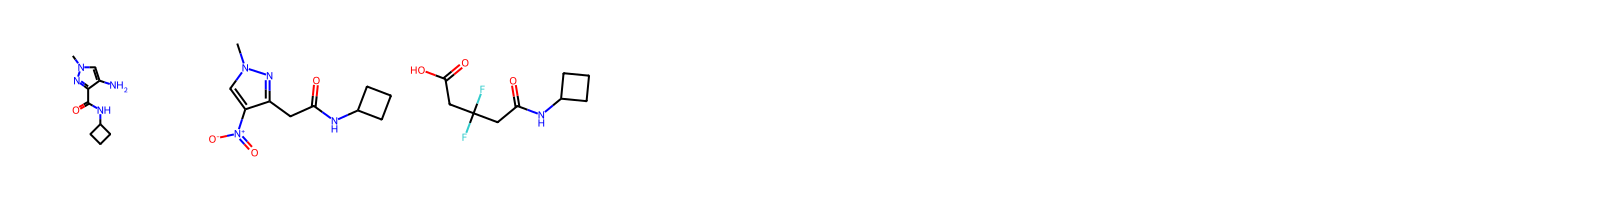

0.6207067290842531		0.6106847879787286		1


(-1.2017120122909546, 0.2845999999999995)

(-2.2398717403411865, 0.5394999999999999)

(-0.9800273180007935, 1.1551999999999998)

In [339]:
from rdkit.Chem import Draw

utility = drug_agent.policy(observations)
index = int(np.argsort(utility)[-1])

mol = drug_env.library[index]
lineage = [mol]
while mol.inspiration:
    mol = mol.inspiration
    lineage.insert(0, mol)

assay_results = [assay(lineage) for assay in assays]
results = [
    utility_function.score(properties)
    for properties in zip(*assay_results)
]

display(Draw.MolsToGridImage(
    [m.mol for m in lineage],
    molsPerRow=8,
    maxMols=10_000
))

print('\t\t'.join(map(str, results)))
display(*zip(*assay_results))